### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [ ]:
nb_fname = "HA1.ipynb"

### Check Python version

In [ ]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [ ]:
import os

nb_dirname = os.path.abspath("")
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in [
    "IHA1",
    "IHA2",
    "HA1",
    "HA2",
], "[ERROR] The notebook appears to have been moved from its original directory"

### Verify correct nb_fname

In [ ]:
from IPython.display import HTML, display

try:
    display(
        HTML(
            r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(
                nb_fname=nb_fname
            )
        )
    )
except NameError:
    assert False, "Make sure to fill in the nb_fname variable above!"

### Verify that your notebook is up-to-date and not corrupted in any way

In [ ]:
import sys

sys.path.append("..")
from ha_utils import check_notebook_uptodate_and_not_corrupted

check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

ModuleNotFoundError: No module named 'ha_utils'

# HA1 - Cats and dogs

<img src="https://cdn.pixabay.com/photo/2015/05/20/10/03/cat-and-dog-775116_960_720.jpg" alt="Image of cats and dogs" style="width: 500px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colour images of dogs and cats. Our goal with this assignment will be to create a classifier that can discriminate between cats or dogs.

The goal is to make sure that you all can independently create, train and evaluate a model using a popular deep learning framework. A secondary goal is also to expose you to GPU computing, either your own or via a cloud computing service. The focus is on implementing the models, and much of the surrounding code is provided for you. You are expected to understand the provided code.

## Using your cloud GPU

### Strong recommendation:
In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-3) in your own computer (these tasks can be solved on the CPU), and leave most of the available hours for solving tasks 4-5, and refining your best model further (and, if you have the spare hours, experiment a bit! (Task 6)).

There may well be difficult to access a cloud GPU, we therefore suggest that you start working with the cloud parts as soon as possible. You do not need to complete tasks 2-3 before you start with the GPU requiring tasks (tasks 4-6). A suggested workflow is to complete the task 0-1, start with task 2 and then work on task 2-3 and 4-6 in parallell.

### Working efficiently:
Training for several epochs just to have your code break at the last validation step is incredibly frustrating and inefficient. Good practice is to first test long training runs with a much simpler dry-run: a single epoch, a few batches et c.

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance. When experimenting, a single epoch is often enough to tell whether your model setup has improved or not.


Hints:
- If you get errors saying you've exhausted the GPU resources, well, then you've exhausted the GPU resources. However, sometimes that's because Pytorch didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough cloud credits to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).
- Solving the computer labs and individual home assignments is a good way to get prepared for this assignment.

**IMPORTANT NOTES:**
- Some cells contain compiled tests. For them to work propery, make sure to keep variable names. For example, if you are asked to create a training dataset, and `train_dataset` is passed to the test, then you should complete the task by updating `train_dataset` variable in your code. But, of course, you can create auxiliary variables.
- Similarly to IHA1 and IHA2, some questions in this notebook will not be graded in detail, but we still expect you to answer them. Those questions are marked with **(0 points)** and, as well as the other questions in this notebook, they may appear in the Inspera test.
- You won't need to train neural networks in Inspera test.

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [2]:
#from utils.tests import ha1_tests
from itertools import chain
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.transforms import Resize, ToTensor, Compose, CenterCrop, Normalize
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

---
## 1. Loading the data and preprocessing

In this part we will set up the data used in this assignment. You need to download it, then we'll walk you through how to make a custom Pytorch dataset abstraction. The abstraction enables you to visualise and play around with the image data and to finally create data loaders, which are necessary for the training.

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats/data) and download the data from there. You should download both the test and train folders together in one zip file (there is a `Download all` button at the bottom of the page). Unfortunately, you need to create a Kaggle account for this.

**Only necessary for tasks 4-6**: Downloading the data to your local computer is quite straight-forward. Sooner or later you will have to upload the data to the cloud instance and that is a bit more tricky. There are a few ways to do it:

 - Jupyter Notebook upload function. When starting the notebook server with the command `jupyter notebook` you are directed to a main page. In the top right corner there is an upload button.
 - Using [`scp`](https://linuxize.com/post/how-to-use-scp-command-to-securely-transfer-files/) to copy files via an ssh connection.
 - Using the [Kaggle CLI](https://github.com/Kaggle/kaggle-api). We have added it to the conda environment.

To begin with, download the data to your local computer and create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      cats        dogs       cats        dogs       cats        dogs       cats        dogs


The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`.
This is just a convenient way of having a smaller dataset to play with for faster prototyping.

We provide you a notebook that shows how to achieve this folder structure (`create_project_notebook_structure.ipynb`), starting from the original `dogs-vs-cats.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

**(1 point)**

For the smaller dataset, we advise you to use 70% of the data as training data (and thereby the remaining 30% for validation data). However, for the larger dataset, you should decide how to split between training and validation.

- What percentage of the larger dataset did you decide to use for training/validation?
- Motivate your decision.

**Your answer:** The larger data set consists of 25'000 images. Considering this not being a hugh data set, but still reasonable big our choice is to split it into 80% for the training set and 20% for the validation set. This choice is made to have sufficient training data, but still have a reliable size of the validation data. Allocating 80% to the training set (20'000 images) will ensure our model to enough data to learn the features distinguishing cats from dogs, and allocating 20% (5'000 images) to the validation data set should be enough to get an accurate evaluation of the model's performance. Generally speaking, as the dataset size increases, it becomes feasible to allocate an even larger portion to the training set while reducing the validation set share, as the increased number of samples in both sets would still allow the model to generalize well without compromising validation accuracy.

Fill in the dataset paths (to be used later by your data loaders):

In [3]:
# TODO: Change the directories accordingly
personalRootJohanna = r"C:\Users\JohannaNorell\Documents\GitHub\DeepMachineLearningHA"
personalRootAxel = r"c:\Users\axelb\Documents\DeepML\DeepMachineLearningHA"

from google.colab import drive
drive.mount('/content/drive')
#personal = personalRootJohanna
#personal = personalRootAxel
personal =  '/content/drive/My Drive/progg/train/progg2'

train_path = personal + r"/train"
val_path = personal + r"/val"
small_train_path = personal + r"/small_train"
small_val_path = personal + r"/small_val"



#If running on GPUs
#small_train_path = r"/home/student/deep-machine-learning/home-assignments/HA1/small_train/"
#small_val_path = r"/home/student/deep-machine-learning/home-assignments/HA1/small_val/"
print(small_train_path)

Mounted at /content/drive
/content/drive/My Drive/progg/train/progg2/small_train


In [4]:
# Correct the path
root = Path(small_train_path)

# Check if the directory exists
if root.exists() and root.is_dir():
    print(f"Directory exists: {root}")
else:
    print(f"Directory does not exist: {root}")

Directory exists: /content/drive/My Drive/progg/train/progg2/small_train


### 1.1 Dataset

To create data loaders we first need to create a dataset abstraction class. The purpose of a data loader is to efficiently provide the CPU/GPU with mini-batches of data. We now work with data complex enough to actually warrant the use of data loaders. In particular, we don't want to load all images into memory at once.

Like before, the data loader is an instance of the Pytorch [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) which wraps a class that inherits from [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), that we create ourselves.
Image classification is such a common task that Pytorch provides a ready-to-use dataset class for this task, called [`ImageFolder`](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#imagefolder).
Using this class however, is rather opaque so for your understanding we will show you how to construct a custom dataset class. If you know this method, you will be able to create a data loader for any dataset you may encounter.

We construct a class `DogsCatsData` as a subclass of `Dataset`.
The dataset subclass holds the actual data, or at least provides access to it.
To make it work with the `DataLoader` class we need to implement two methods:

- `__getitem__(self, index)`: return the `index`'th sample, i.e. a single pair of (image, label)
- `__len__(self)`: simply return the total number of samples $N$ in the dataset.

These methods are so called Python "magic" methods, signified by the leading and closing double underscores.
They typically enable special syntax for a class: `__getitem__` enables indexing of a class, and `__len__` enables calling the `len` function:
```python
# Consider an instance `data` of a class `MyDataset` implementing `__getitem__` and `__len__`
data[10] # returns the item with index 10 in `data`
len(data) # returns the length/size of `data`
```
We will return to why these are needed in the `DataLoader` wrapping class

Now, to the actual implementation: The idea is to have the dataset class only store the filenames of the images (and the corresponding label), not the images themselves. We will find and store the filenames in the constructor. The `__getitem__` method will use the index to look up the correct filename and load it into memory.
The `__len__` method is left for you to implement.

Being able to use and understand code you have not written is an important ability. Below you are required to interact with the dataset class with a simple completion of the implementation and by extracting some data from the class. This is partly to ensure that you understand this specific class and partly to show you some tools for exploring new code.

In [5]:
class DogsCatsData(Dataset):
    def __init__(self, root, transform, dog_label=1, cat_label=0):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform
        self._dog_label = dog_label
        self._cat_label = cat_label

        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        # YOUR CODE HERE
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels

        Helper method for the constructor
        """
        # Iterator over dog filpath
        dog_paths = self._collect_imgs_sub_dir(self.root / "dogs")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        dog_paths_and_labels = map(lambda path: (path, self._dog_label), dog_paths)
        # Same for cats
        cat_paths = self._collect_imgs_sub_dir(self.root / "cats")
        cat_paths_and_labels = map(lambda path: (path, self._cat_label), cat_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(
            list(chain(dog_paths_and_labels, cat_paths_and_labels)),
            key=lambda x: x[0].stem,
        )

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.jpg")

    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.

        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

**(2 points)**

Show that you understand the implementation by creating an instance called `example_dataset` of it. Create it from the small training set.
Use the instance to:
- print the number of samples in it
- print the label of the second sample, note that this is a number (0 or 1)

In [6]:
# The Dataset constructor has a transform attribute, we will cover it below. Just use this for now:
transform = Compose([ToTensor()])
root = small_train_path
example_dataset = DogsCatsData(root, transform)
number_of_samples = len(example_dataset)
img, label = example_dataset[2]

print(f"The number of samples is: {number_of_samples}")
print(f"The label of the second sample is: {label}")

The number of samples is: 3500
The label of the second sample is: 0


In [ ]:
# Test case for `number_of_samples`
ha1_tests.test_number_of_samples(example_dataset, number_of_samples, DogsCatsData)

In [ ]:
# Test case for `label`
ha1_tests.test_label(example_dataset, label, DogsCatsData)

Test passed


It is vital to explore your data, but it can be tricky to deal with images in the tensor format.
To aid you, use the below helper function to visually inspect your images.

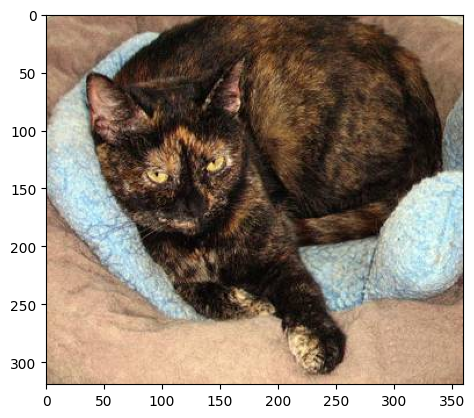

In [7]:
def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """

    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor` "
            + "use the `ToTensor` transformation to convert the images to tensors."
        )

    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)


# Example usage
_, axis = plt.subplots()
some_random_index = 200 #453
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor, label = example_dataset[some_random_index]
display_image(axis, image_tensor)

### 1.2 Preprocessing
The `DogsCatsData` class constructor has an argument called `transform`. It allows us to transform or preprocess all the images in a batch, from the raw image data to a more suitable format. There are multiple motivations for preprocessing:

- Some transformations might be needed to actually make the data work with our network (reshaping, permuting dimensions et c.).
- Make the training more efficient by making the input dimensions smaller, e.g. resizing, cropping.
- Artificially expanding the training data through [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/)
- We have some clever idea of how to change the data to create a simpler optimisation problem.

We do not expect you to do data augmentation, but feel free to preprocess the data as you see fit. Use the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision-transforms) to view available transforms. Extra important is the `Compose` transformation, which is a meta-transformation which composes actual ones, and the `ToTensor` transformation which is the simplest way to go from image to tensor format.


Hints:
- Revisit the `DogsCatsData` example usage to see how to use the `Compose` and `ToTensor` transformations.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned Pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial as it speeds up training. The CNN's do surprisingly well on 64x64 or even 32x32 images. Shorter training cycles give you more time to experiment! Note: The VGG network used later in this assignment is specialised for images that are 224x224.

We encourage you to explore the data and choose transformations that you believe to be useful. For exploration we provide you with a helper function to visually compare transformations side by side:

In [8]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of DogsCatsData datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.

    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)

    Args:
        transformations (list(DogsCatsData)): list of dataset instances with different transformations
        index (int): Index of the sample in the dataset you wish to compare.
    """

    # Here we combine two functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, e.g. a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError(
            "All elements in the `transformations` list need to be of type Dataset"
        )

    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)

    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title(f"transf: {counter}")
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

In [19]:
# Explore your dataset in this cell, you do not need to produce any results.
image_tensor, label = example_dataset[3]
image_data = image_tensor.permute(1, 2, 0).numpy()
height, width, _ = image_data.shape
print(f"Height: {height}, width: {width}, ratio: {height/width}")
img_size = None
train_dataset = None


#Creating transformations
root = small_train_path

transform1 = Compose([
    #ConvertImageDtype(torch.uint8), #To make sure input are uint8 (not necessary but good if not sure that input is uint8)
    #CenterCrop(200),
    Resize(size=(64, 64), antialias=True),
    ToTensor() #v2 uses ToImage to convert to tensor
])

img_size = 64
transform2 = Compose([
    Resize(img_size),
    CenterCrop(img_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])


best_transformer = transform2 #The transformer I visually examine to be the best one right now

Height: 263, width: 300, ratio: 0.8766666666666667


**(0 points)**

Normalisation of the training data is popular in pre-processing. What is the argument or intuition for why this is a beneficial transformation?

**Your answer:**

If using gradient-based optimization (like when we use stochastic gradient descent etc.) it helps the method balance features in different scales. By ensuring that all features are considered equally it helps the model to converge faster by considering normalized features in comparison to not normalizing. Also, features with larger values can cause the optimization process to oscillate and slow down the learning as features with larger values dominate the gradient updates. Thus, normalizing will help to balance the gradients and make the updates more stable. Lastly it also improves generalization by not relying on the absolute values scale in specifikt features in the training data, but instead more accurately indentifying the patterns within the data.

### 1.3 Data loaders
With our dataset class implementation in place, creating a `DataLoader` instance is simple.

The data loader class wraps the dataset and provides a way to iterate over batches in the training loop.
To produce batches, it gets the total number of samples $N$ with the dataset's `__len__` method.
It divides the indices $1, \dots, N$ into equally sized index batches with $B$ (batch size) elements. A particular batch with pairs of image and label is created by calling the dataset's `__getitem__` method with the indices in the batch. NB: the last batch in an epoch might be smaller if $N$ is not divisible by $B$.

Create the data loaders needed for training (use the small version of the data), in the cell below.
The `DataLoader` class is documented [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) , but it's not that much to it.
You simply create a data loader with a dataset instance and some other (self-explanatory) settings:

```python
train_dataloader = DataLoader(example_dataset, batch_size=batch_size, shuffle=True)
```

**(1 point)**

Create data loaders required for training and validation.

Hints:
- The specified `batch_size` should be chosen so that you train fast but don't run out of memory. You need to figure this out empirically; start small and increase the batch size until you run out of memory. Beyond this pragmatic approach, feel free to contribute to the highly contested scientific debate about the relation between batch size and generalisation.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably.

In [21]:
batch_size = 512 #To be empirically tested to find optimal size
num_workers = 4 #Test later if changing this will speed up training

small_train_dataset = DogsCatsData(small_train_path, best_transformer)
small_val_dataset = DogsCatsData(small_val_path, best_transformer)

train_dataloader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(small_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


In [22]:
for i, (images, labels) in enumerate(train_dataloader):
    print(f"Batch {i+1}: Loaded {len(images)} images")
    if i == 2:
        break

Batch 1: Loaded 64 images
Batch 2: Loaded 64 images
Batch 3: Loaded 64 images


In [ ]:
# Test case for `train_dataloader`
ha1_tests.test_dataloader(train_dataloader)

Test passed


In [ ]:
# Test case for `val_dataloader`
ha1_tests.test_dataloader(val_dataloader)

Test passed


**(0 points)**

What batch size did you use and why?

**Your answer:** When choosing batch size we wanted to balance the speed of training, memory constraints and model convergence. We started of arbritrary and tried bigger batch sizes to find something optimal. To begin with, we hade 64 (for the small training data set) which offered good convergence but slow training. When trying to increase the batch size to 1024, it significantly speeded up training but also significantly reduced performance. Thus, we ended up choosing a batch size of 512 for the small training data set.

---
## 2. Training

### 2.1 The first model

**(3 points)**

Now, it's time to create a model called `FirstCnn`. To begin with, you have to create a CNN to an exact specification. After that, you will get the chance to be more creative.

For the first model, create a network that:
- Inherits from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)
- Implements a constructor `__init__(self, img_size)`, a `forward(self, input_batch)` method and whatever other helper methods you deem necessary. Note that a (square) image size should be a parameter in the model's constructor. While not strictly necessary, it is an acceptable way of handling varying input dim's and it is convenient for testing.
- Can handle square images of arbitrary size and arbitrary large mini-batch sizes (within memory limits, of course). You may assume that there are always three colour channels, i.e., a mini-batch will have the shape `(batch size = B, num channels = 3, img size = D, D)`
- Has layers:
    1. Two convolutional layers, each with 10 filters, kernel size = 3, stride = 1, padding = 0
    2. A single fully connected layer.
    - *Note:*
        - Related layers such as a pooling operation are optional.
        - Choose suitable activation functions.
        - Take the layers from [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module, and **not** from `torch.nn.functional` module.
- Outputs the probability of the image belonging to the class 'dog'. Technically the output should consist of `B` probabilities, one for each image in the mini-batch and so have the shape `(B,)`.

Hints:

- The subpage for [`torch.nn`](https://pytorch.org/docs/stable/nn.html) is a good place to find the layer specifics.
- Going from the last CNN layer to the final fully connected layer is not trivial. The convolutions produces feature maps which we can think of as an image with many channels, while the fully connected layer expects a row vector as input. Calculate how many output neurons the convolutions produce and use `.reshape` to make your tensor fit the fully connected layer. It is also common to see the `.view` and `.squeeze` methods to do the same thing. They basically do the same thing (apart from some differences in internal memory management) but are less transparent. *Hint within the hint:* remember that the fully connected layers expects a *batch* of 1D tensors.


In [23]:
class FirstCnn(nn.Module):
    def __init__(self, img_size): #img_size should be square
        super().__init__()

        kernel_size = 3
        stride = 1
        padding = 0

        out_dim1 = int((img_size - (kernel_size - 1) - 2 * padding) / stride)
        out_dim2 = int((out_dim1 - (kernel_size - 1) - 2 * padding) / stride)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=kernel_size, stride=stride, padding=padding)
        self.fc1 = nn.Linear(in_features=10*out_dim2*out_dim2, out_features = 1)

        self.sigmoid = nn.Sigmoid()
        self.activation = nn.ReLU()

    def forward(self, input_batch):
        x = self.conv1(input_batch)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.activation(x)

        x = torch.flatten(x,1)
        x = self.fc1(x)

        x = self.sigmoid(x) #Output probabilities for class 1
        x = x.squeeze(1) #Reshaping output to match shape (B,)

        return x

In [ ]:
# Test case 1 for `FirstCnn`
# Note that the test takes the actual class, not an instance of it, as input.
ha1_tests.test_model(FirstCnn)

Test passed.


In [ ]:
# Test case 2 for `FirstCnn`
ha1_tests.test_architecture(FirstCnn)

Test passed


**(0 points)**

You have been told that one of the benefits of CNN is that it can handle input of different sizes. Yet, you needed to know the image size in the constructor.
Explain how you made your model handle different input sizes and why it is necessary, despite it being a CNN.

**Your answer:**
When iniatting the CNN we take the image size as a parameter so that it can be selected by the user. Convolutional layers can handle different sizes but the fully connected layer expect a specific size why this has to be specified.

### 2.2 The training loop

**(2 points)**

You have already seen quite a few training loops in the preparations. Below we provide you with an example of a basic one that you can use.
You need to provide an implementation that maps network outputs (probabilites) to hard labels.

An extra point is awarded if you provide a vectorised implementation.

In [24]:
def output_to_label(z):
    """Map network output z to a hard label {0, 1}

    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """

    hard_preds = (z >= 0.5).long()
    return hard_preds

In [ ]:
# Test case for `output_to_label` function
ha1_tests.test_output_to_label(output_to_label)

Test passed


In [25]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    best_val_acc = 0
    best_model = None
    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # save state of model
            best_model = model.state_dict()
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs, best_model


def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )

    return model, train_loss_batches, train_acc_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

**(1 point)**

Use the training loop to train your model, using the two dataloaders you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Which `loss_fn` should you use? Think first about what is suitable for this problem, not what seems to work better empirically.
- Training on a CPU is slow and in the beginning you just want to verify that your architecture actually produces a predicition with the correct shape. Make everything you can to speed up the prototyping phase, e.g. train only for a single epoch and make the images ridiculously small.

In [ ]:
train_loader = train_dataloader
val_loader = val_dataloader

model = FirstCnn(64)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

num_epochs = 20
print_every = 10

first_batches_per_epoch = int(len(small_train_dataset)/512)+1


first_model, first_train_losses, first_train_accs, first_val_losses, first_val_accs, best_first_model = training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
)

Starting training
Epoch 1/20: Train loss: 0.685, Train acc.: 0.563, Val. loss: 0.681, Val. acc.: 0.568
Epoch 2/20: Train loss: 0.669, Train acc.: 0.607, Val. loss: 0.671, Val. acc.: 0.580
Epoch 3/20: Train loss: 0.658, Train acc.: 0.629, Val. loss: 0.666, Val. acc.: 0.592
Epoch 4/20: Train loss: 0.648, Train acc.: 0.636, Val. loss: 0.660, Val. acc.: 0.588
Epoch 5/20: Train loss: 0.642, Train acc.: 0.640, Val. loss: 0.656, Val. acc.: 0.605
Epoch 6/20: Train loss: 0.635, Train acc.: 0.649, Val. loss: 0.655, Val. acc.: 0.613
Epoch 7/20: Train loss: 0.626, Train acc.: 0.658, Val. loss: 0.651, Val. acc.: 0.601
Epoch 8/20: Train loss: 0.620, Train acc.: 0.661, Val. loss: 0.652, Val. acc.: 0.608
Epoch 9/20: Train loss: 0.614, Train acc.: 0.669, Val. loss: 0.646, Val. acc.: 0.616
Epoch 10/20: Train loss: 0.610, Train acc.: 0.669, Val. loss: 0.646, Val. acc.: 0.618
Epoch 11/20: Train loss: 0.603, Train acc.: 0.682, Val. loss: 0.641, Val. acc.: 0.623
Epoch 12/20: Train loss: 0.597, Train acc.: 0

**(0 points)**

Which loss function did you use and why? In our "Cats vs Dogs" problem, the dataset is balanced in terms of classes. What would you change if there was a class imbalance (for example, if we had much less dog images)?


**Your answer:**
We picked Binary cross entropy.  This loss function works by comparing the predicted probability for each sample (between 0 and 1) with the actual label (0 for cats and 1 for dogs) and is made for binary tasks

### 2.3 Visualisation

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.
Note that the given training loop produces metrics at different intervals for training and validation, make sure that you align your metrics in a way that makes sense.

In [28]:
import matplotlib.pyplot as plt
def plot_loss_and_acc(train_losses, val_losses, train_accs, val_accs, batches_per_epoch):

    epoch_train_losses = [
        sum(train_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) / batches_per_epoch
        for i in range(len(val_losses))
    ]

    epoch_train_accs = [
        sum(train_accs[i * batches_per_epoch:(i + 1) * batches_per_epoch]) / batches_per_epoch
        for i in range(len(val_losses))
    ]

    epochs = range(1, len(val_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot the loss
    ax1.plot(epochs, epoch_train_losses, label="Training Loss")
    ax1.plot(epochs, val_losses, label="Validation Loss", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot the accuracy
    ax2.plot(epochs, epoch_train_accs, label="Training Accuracy")
    ax2.plot(epochs, val_accs, label="Validation Accuracy", linestyle="--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Training and Validation Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

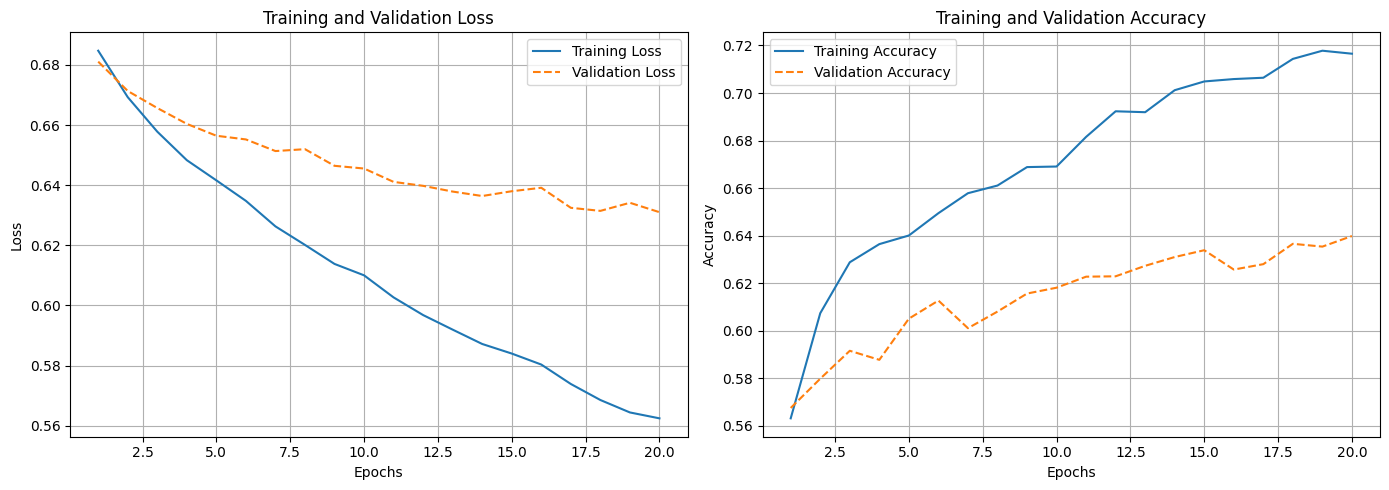

In [ ]:

plot_loss_and_acc(first_train_losses, first_val_losses, first_train_accs, first_val_accs, first_batches_per_epoch)


**(2 points)**

Based on these, what would you suggest for improving your model? Why?

**Your answer:**
We want to try residual connect, as deep networks often suffer from vanishing gradients, making it difficult for them to learn as layers get deeper. Residual connections help by allowing the gradient to flow through the network more effectively during backpropagation, which can improve convergence and performance. We also want to try a few different activation functions, as PRelu which has a learn parameter for negative values often improves models. Batch Normalization, can also be tested, it normalizes the output of each layer, which help stabilize training.

We will also try making the network more complex by both adding channels and more layers. This to try to capture more complex relations and increase the amount of pixels that convolutional layers take in to account, which is possible by the multple layers. This will come with the risk of overfitting though which we will have to handle by using dropout layers

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights, optimizer state, losses and accuracies). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below.

In [ ]:
# Assuming that you named your model "first_model" and training statistics as following
torch.save(
    {
        "model_state_dict": best_first_model,
        "train_losses": first_train_losses,
        "train_accs": first_train_accs,
        "val_losses": first_val_losses,
        "val_accs": first_val_accs,
    },
    "./first_model.ckpt",
)

saved_first_model = FirstCnn(img_size)  # fill-in the arguments if needed
checkpoint = torch.load("first_model.ckpt")
saved_first_model.load_state_dict(checkpoint["model_state_dict"])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint["val_accs"])

Validation accuracies: [0.5675059159596761, 0.5798155268033346, 0.591556171576182, 0.5877538720766703, 0.6050693790117899, 0.6126958727836609, 0.6010701258977255, 0.6080510417620341, 0.6156392296155294, 0.618101159731547, 0.6227350433667501, 0.6228936910629272, 0.6273032824198405, 0.6310016314188639, 0.633868396282196, 0.625727653503418, 0.6280035575230917, 0.6365655660629272, 0.6353838443756104, 0.6398372054100037]


<ipython-input-65-d819787f9df1>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("first_model.ckpt")


---
## 3. Improving your model

**(3 points)**

Now you are free to create whichever model you want. A simple improvement based on your analysis of the above results is fine, or you can do something more ambitious. When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning. *Hint*: reducing the input image size facilitates training.

**NOTE**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of **one model**. Remove all code related to the models that were not chosen.

**NOTE 2**: It may feel like you are stuck trying to make the model perform better. Understanding the mechanics and a lot of experimentation will help gain intuition. But it is also beneficial for you to explore some of the popular architectures, building blocks, and techniques (e.g., residual blocks, Inception modules, dilated convolutions, depthwise separable convolutions, data augmentation etc). You will need to explore/study a lot during the project work, so we highly encourage you to already **start looking for and analyzing existing approaches** and learn how to use them for your tasks.

In [ ]:
class ImprovedCnn(nn.Module):
    def __init__(self, img_size):  # img_size should be square
        super().__init__()

        kernel_size = 3
        stride = 1
        padding = 1  # Adjusted for same padding

        # First conv block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(32)

        # Third conv block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(64)

        # Identity convolutions for residual connection
        self.one_by_one_conv = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0)
        # Calculate the final feature map size
        final_conv_size = img_size // 8

        # Fully connected layers
        self.fc1 = nn.Linear(64 * final_conv_size * final_conv_size, 256)
        self.fc2 = nn.Linear(256, 1)

        self.activation = nn.PReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_batch):
        # First block with residual connection
        residual = input_batch
        x1 = self.pool(self.activation(self.bn1(self.conv1(input_batch))))
        x1 = self.activation(x1)

        # Second block
        x2 = self.pool(self.activation(self.bn2(self.conv2(x1))))
        x2 = self.activation(x2)

        # Third block
        x3 = self.pool(self.activation(self.bn3(self.conv3(x2))))
        x3 = self.activation(x3)
        x3 = self.dropout(x3)

        # Resize residual
        residual = self.pool(self.one_by_one_conv(residual))
        residual= self.pool(residual)
        residual = self.pool(residual)
        x3+=residual

        # Flatten and fully connected layers
        x = torch.flatten(x3, 1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.squeeze(1)

In [ ]:
train_dataset = DogsCatsData(small_train_path, best_transformer)
val_dataset = DogsCatsData(small_val_path, best_transformer)

batch_size = 64 #To be empirically tested to find optimal size, bigger than small training set batch size
num_workers = 0 #Test later if changing this will speed up training

impr_batches_per_epoch = int(len(train_dataset)/batch_size)+1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
train_loader = train_dataloader
val_loader = val_dataloader
improved_model = ImprovedCnn(64)
optimizer = optim.Adam(improved_model.parameters(), lr=0.0001, weight_decay=0.0001)
loss_fn = nn.BCELoss()

num_epochs = 20
print_every = 10

improved_model, impr_train_losses, impr_train_accs, impr_val_losses, impr_val_accs, best_improved_model = training_loop(
    improved_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
)

Starting training
Epoch 1/20: Train loss: 0.781, Train acc.: 0.514, Val. loss: 0.648, Val. acc.: 0.645
Epoch 2/20: Train loss: 0.725, Train acc.: 0.524, Val. loss: 0.777, Val. acc.: 0.364
Epoch 3/20: Train loss: 0.691, Train acc.: 0.558, Val. loss: 0.654, Val. acc.: 0.649
Epoch 4/20: Train loss: 0.671, Train acc.: 0.575, Val. loss: 0.710, Val. acc.: 0.481
Epoch 5/20: Train loss: 0.650, Train acc.: 0.615, Val. loss: 0.730, Val. acc.: 0.449
Epoch 6/20: Train loss: 0.633, Train acc.: 0.641, Val. loss: 0.653, Val. acc.: 0.640
Epoch 7/20: Train loss: 0.625, Train acc.: 0.635, Val. loss: 0.691, Val. acc.: 0.558
Epoch 8/20: Train loss: 0.616, Train acc.: 0.664, Val. loss: 0.687, Val. acc.: 0.577
Epoch 9/20: Train loss: 0.607, Train acc.: 0.672, Val. loss: 0.630, Val. acc.: 0.657
Epoch 10/20: Train loss: 0.595, Train acc.: 0.679, Val. loss: 0.663, Val. acc.: 0.619
Epoch 11/20: Train loss: 0.594, Train acc.: 0.681, Val. loss: 0.626, Val. acc.: 0.655
Epoch 12/20: Train loss: 0.593, Train acc.: 0

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

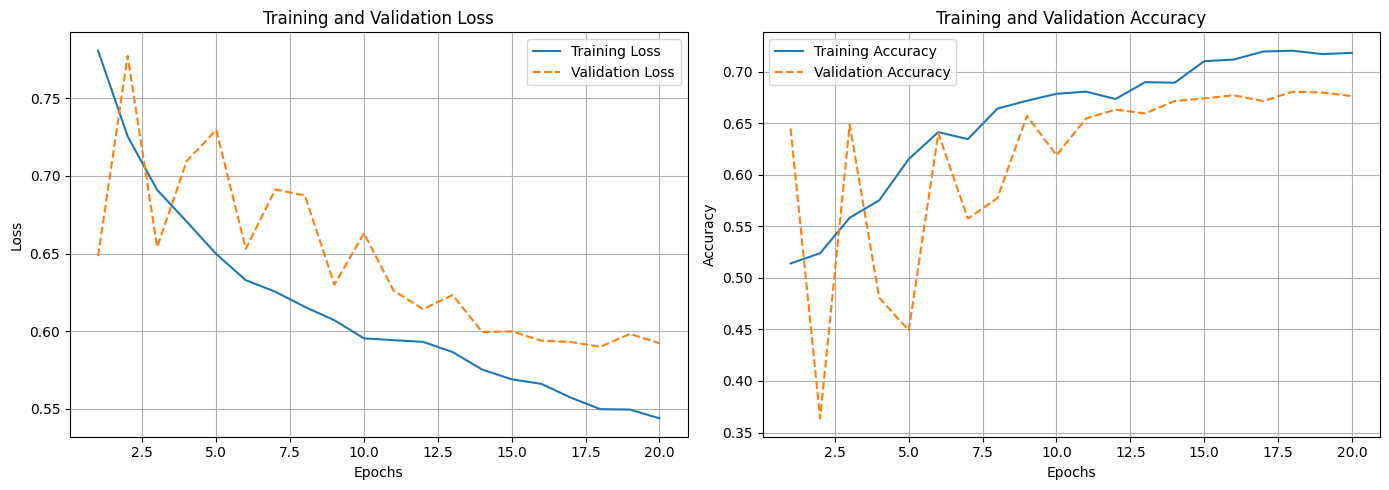

In [ ]:
plot_loss_and_acc(impr_train_losses, impr_val_losses, impr_train_accs, impr_val_accs, impr_batches_per_epoch)

**(1 point)**

How does the model perform, compared to the first CNN model? Create one plot with the training accuracy and another with the validation accuracy of the two models.

In [27]:
def compare_model_accuracy(first_train_accs, first_val_accs, impr_train_accs, impr_val_accs, first_batches_per_epoch, impr_batches_per_epoch):
    # Plotting training and validation losses and accuracies

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    first_epoch_train_accs = [
        sum(first_train_accs[i * first_batches_per_epoch:(i + 1) * first_batches_per_epoch]) / first_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    impr_epoch_train_accs = [
        sum(impr_train_accs[i * impr_batches_per_epoch:(i + 1) * impr_batches_per_epoch]) / impr_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    epochs = range(1, len(first_val_accs) + 1)

    # Plot the loss on the first subplot
    ax1.plot(epochs, first_epoch_train_accs, label="First Model Training Accuracy")
    ax1.plot(epochs, impr_epoch_train_accs, label="Improved Model Training Accuracy", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Accuracy")
    ax1.set_title("First- and improved model's training accuracy")
    ax1.legend()
    ax1.grid(True)

    # Plot the accuracy on the second subplot
    ax2.plot(epochs, first_val_accs, label="First Model Validation Accuracy")
    ax2.plot(epochs, impr_val_accs, label="Improved Model Validation Accuracy", linestyle="--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Validation Accuracy")
    ax2.set_title("First- and improved model's validation accuracy")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

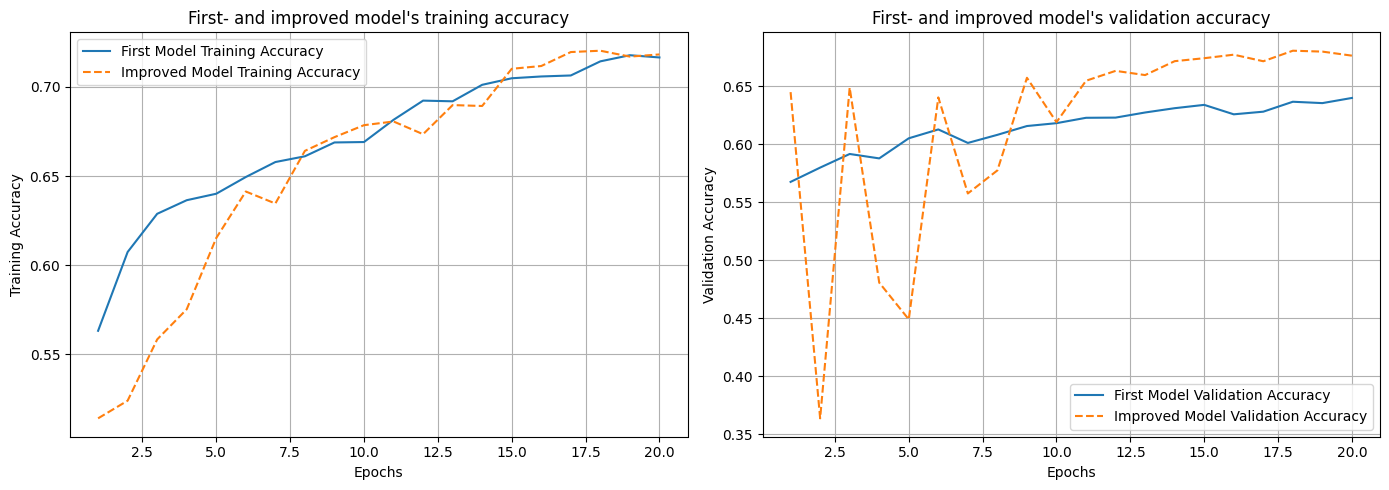

In [ ]:
compare_model_accuracy(first_train_accs, first_val_accs, impr_train_accs, impr_val_accs, first_batches_per_epoch, impr_batches_per_epoch)

**(1 point)**

Did your results improve? What problems did your improvements fix? Explain why, or why not.

**Your answer:** We saw increased perfomance compared to the baseline. We increaste the amount of layer, added more channels in each layer, added batch normalization and a residual connection, as well as changing activation to PRelu. The increasing number of channels allows the model to learn more complex hierarchical features, as each layer has greater representational power. Batch normalization helps stabilize training by normalizing the input to each layer, making training faster and more stable. The residual connect allows the original input features to bypass the deeper layers and be directly added to the feature maps, which can help mitigate the vanishing gradient problem. Max pooling helps with efficency. PRelu was chosen as it has work well in previous networks we have created utilizing residual connections.

However, the added complexity increase the risk of overfitting why a dropout layer is used to help mitigate it aswell as weight decay in the optimizer. We also save the model weight from the best epoch and not the last one.

Save your model to disk.

In [ ]:
# Assuming that you named your model and statistics as "impr_..."
torch.save(
    {
        "model_state_dict": best_improved_model,
        "train_losses": impr_train_losses,
        "train_accs": impr_train_accs,
        "val_losses": impr_val_losses,
        "val_accs": impr_val_accs,
    },
    "./improved_model.ckpt",
)

# YOUR CODE HERE

---
## 4. Transfer Learning

**From now, training on a CPU will likely not be feasible. If your computer has a GPU, try it out! Otherwise, now is the time to connect to your cloud instance**

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with our own top network, designed for dog/cat classification.
This top network is often called the "head" in transfer learning.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/vision/stable/models.html?highlight=vgg#torchvision.models.vgg16).

In [29]:
vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# If you had to downgrade Python+torch+torchvision
# (i.e. your operating system does not support the provided environment file):
# the syntax for loading vgg16 weights is different in older version:
#     vgg_model = models.vgg16(pretrained=True)

print(vgg_model.classifier)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


**(1 point)**

Create a new model named `head` as a so-called head network to the base VGG model.
VGG is a relatively deep network so think about what would be a reasonable model head for transfer learning.

*Hint:*
- You can access and modify the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [34]:

# Modify the fully connected layers for binary classification
# The original fully connected layers are designed for 1000 classes, we'll change it for 2 (cats and dogs)
head = nn.Sequential(
    nn.Linear(25088, 4096),  # input from flattened convolutional layer
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 1024),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1024, 1),
    nn.Sigmoid(),
    nn.Flatten(start_dim=0)
)

In [ ]:
# Test case for `head`
ha1_tests.test_transfer_learning_head(head)

Test passed


**(2 points)**

Now add the new model on top of VGG. You full model should be stored in the `vgg_model` variable.

In [35]:
vgg_model.classifier = head

In [ ]:
# Test case 1 for `vgg_model`
ha1_tests.test_vgg_model_1(vgg_model, head)

Test passed


In [ ]:
# Test case 2 for `vgg_model`
ha1_tests.test_vgg_model_2(vgg_model, head)

Test passed


### 4.1 Using VGG features

**(1 point)**

Now we're almost ready to train the new model. For transfer learning we want to freeze all but the top layers in your architecture (i.e. signal to the optimizer that the bottom layers should not be changed during optimization). We do that by setting the attribute `requires_grad` of every parameter in the feature sub-network of `vgg_model` to `False`.

In [ ]:
for param in vgg_model.features.parameters():
    param.requires_grad = False

In [ ]:
# Test case for `vgg_model`
ha1_tests.test_vgg_model_parameters_for_transfer_learning(vgg_model)

Test passed


**(1 point)**

Prepare dataloaders for transfer learning. Don't forget that the VGG network is specialised for images of a certain size.

In [43]:
img_size = 224  # Example square size
transformer = Compose([
    Resize(img_size),
    CenterCrop(img_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize

])

small_train_dataset = DogsCatsData(small_train_path, transformer)
small_val_dataset = DogsCatsData(small_val_path, transformer)

batch_size = 64 #To be empirically tested to find optimal size
num_workers = 8 #Test later if changing this will speed up training

train_dataloader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(small_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

vgg_batches_per_epoch = int(len(small_train_dataset)/batch_size)+1

In [ ]:
# Test case for `train_dataloader`
ha1_tests.test_dataloader_for_transfer_learning(train_dataloader)

In [ ]:
# Test case for `val_dataloader`
ha1_tests.test_dataloader_for_transfer_learning(val_dataloader)

Test passed


**(1 point)**

Perform the transfer learning by training the top layers of your model.

In [ ]:
# Set up the optimizer to only update the head of the network (the classifier part)
optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=0.001)

# Use Binary Cross-Entropy Loss for binary classification (cat or dog)
loss_fn = nn.BCELoss()

# Number of epochs and how often to print progress
num_epochs = 2
print_every = 10

# Call the training loop
vgg_model, vgg_train_losses, vgg_train_accs, vgg_val_losses, vgg_val_accs, best_vgg_model = training_loop(
    model=vgg_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=num_epochs,
    print_every=print_every
)

Starting training
	Batch 10/55: 	Train loss: 0.853, 	Train acc.: 0.973, 	Val. loss: 0.235, 	Val. acc.: 0.981
	Batch 20/55: 	Train loss: 0.392, 	Train acc.: 0.983, 	Val. loss: 0.516, 	Val. acc.: 0.974
	Batch 30/55: 	Train loss: 0.608, 	Train acc.: 0.978, 	Val. loss: 0.435, 	Val. acc.: 0.979
	Batch 40/55: 	Train loss: 0.600, 	Train acc.: 0.977, 	Val. loss: 0.386, 	Val. acc.: 0.975
	Batch 50/55: 	Train loss: 1.318, 	Train acc.: 0.969, 	Val. loss: 0.532, 	Val. acc.: 0.982
Epoch 1/2: Train loss: 0.909, Train acc.: 0.974, Val. loss: 0.646, Val. acc.: 0.980
	Batch 10/55: 	Train loss: 0.392, 	Train acc.: 0.983, 	Val. loss: 0.863, 	Val. acc.: 0.968
	Batch 20/55: 	Train loss: 0.307, 	Train acc.: 0.978, 	Val. loss: 0.518, 	Val. acc.: 0.984
	Batch 30/55: 	Train loss: 0.219, 	Train acc.: 0.989, 	Val. loss: 0.430, 	Val. acc.: 0.983
	Batch 40/55: 	Train loss: 0.373, 	Train acc.: 0.988, 	Val. loss: 0.370, 	Val. acc.: 0.982
	Batch 50/55: 	Train loss: 0.675, 	Train acc.: 0.981, 	Val. loss: 0.569, 	Val. 

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

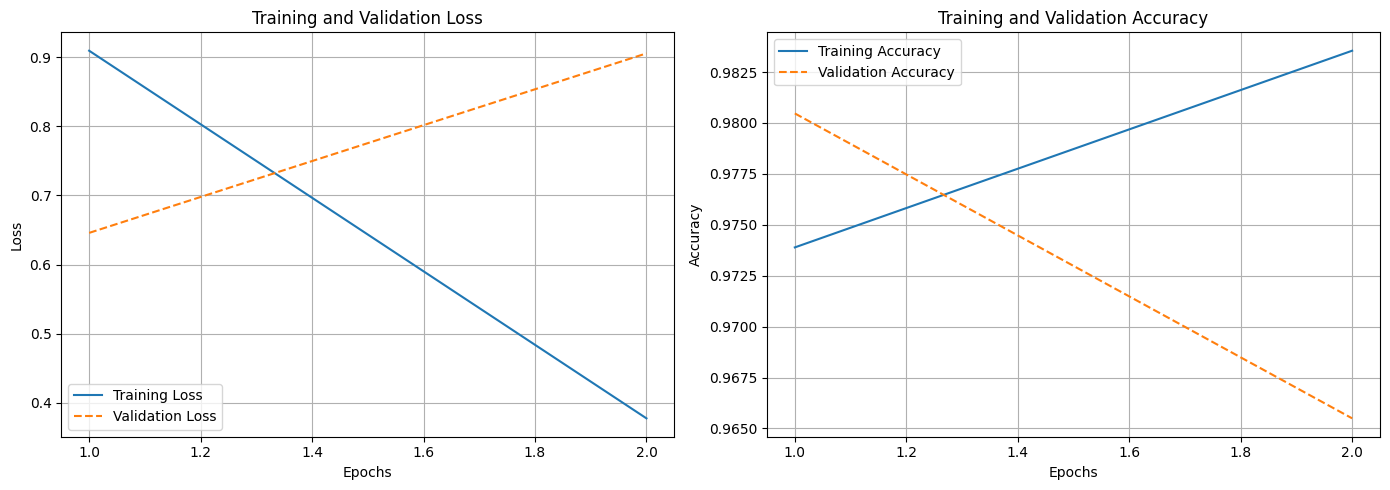

In [ ]:
vgg_batches_per_epoch = int(len(small_train_dataset)/batch_size)+1
plot_loss_and_acc(vgg_train_losses, vgg_val_losses, vgg_train_accs, vgg_val_accs, vgg_batches_per_epoch)

**(1 point)**

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [48]:
def compare_model_accuracy2(first_train_accs, first_val_accs, impr_train_accs, impr_val_accs, first_batches_per_epoch, impr_batches_per_epoch):
    # Plotting training and validation losses and accuracies

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    first_epoch_train_accs = [
        sum(first_train_accs[i * first_batches_per_epoch:(i + 1) * first_batches_per_epoch]) / first_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    impr_epoch_train_accs = [
        sum(impr_train_accs[i * impr_batches_per_epoch:(i + 1) * impr_batches_per_epoch]) / impr_batches_per_epoch
        for i in range(len(impr_val_accs))
    ]

    # Create x values (epochs) for both models
    first_epochs = list(range(1, len(first_epoch_train_accs) + 1))
    impr_epochs = list(range(1, len(impr_epoch_train_accs) + 1))

    # Plot training accuracy on the first subplot
    ax1.plot(first_epochs, first_epoch_train_accs, label="Improved Model Training Accuracy")
    ax1.plot(impr_epochs, impr_epoch_train_accs, label="VGG Model Training Accuracy", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Accuracy")
    ax1.set_title("Improved and VGG model training accuracy")
    ax1.legend()
    ax1.grid(True)

    # Plot validation accuracy on the second subplot
    ax2.plot(first_epochs, first_val_accs, label="Improved Model Validation Accuracy")
    ax2.plot(impr_epochs, impr_val_accs, label="VGG Model Validation Accuracy", linestyle="--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Validation Accuracy")
    ax2.set_title("Improved and VGG model validation accuracy")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


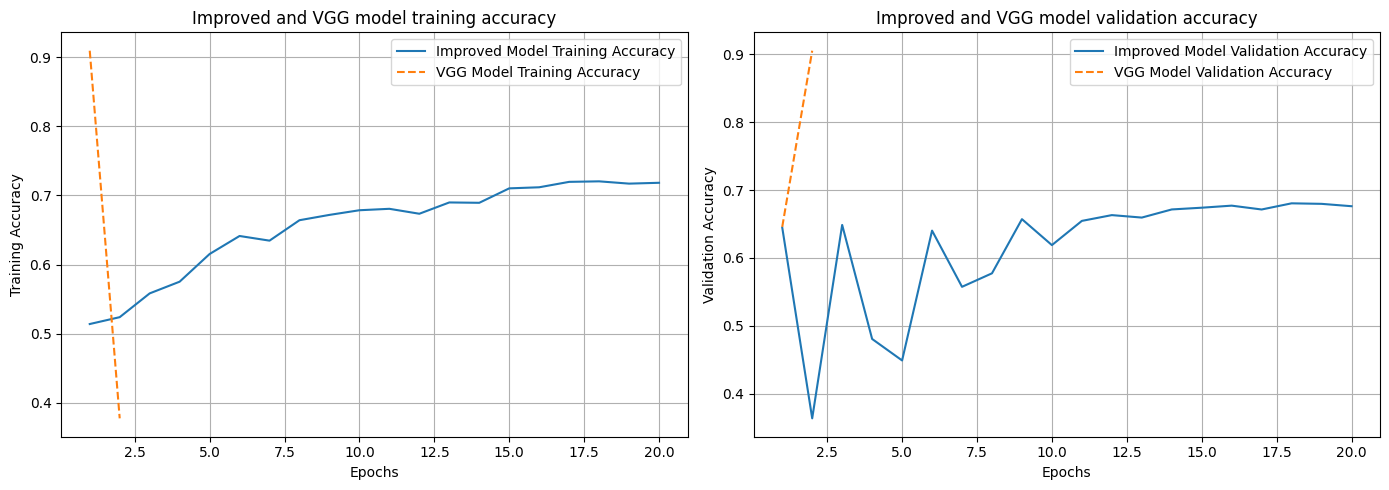

In [ ]:
compare_model_accuracy2(impr_train_accs, impr_val_accs, vgg_train_losses, vgg_val_losses, impr_batches_per_epoch, vgg_batches_per_epoch)

**(1 point)**

Compare these results.

- Which approach worked best, starting from scratch or doing transfer learning?
- Reflect on whether your comparison is fair or not.

**Your answer:** (fill in here)

The transfered learning was significantly better. Transfer learning allows us to fine-tune models with fewer training steps and computational resources, since the bulk of feature learning is already done. In contrast, training from scratch requires much more time to achieve comparable performance. We could build similarly complex models ourself but the computatinal resorces and the data needed to train it is not something we have.

**(0 points)**

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** ImageNet is a large-scale, highly diverse dataset used for complex, multi-class classification tasks, while Dogs vs Cats is a smaller, more focused dataset designed for binary classification

**(0 points)**

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** Neural networks, particularly in their early layers, learn general visual patterns that are useful across different tasks. And it is also very probable that of the 1000 labels that ImageNet has, 2 are cat and dog.

**(0 points)**

In which scenario would transfer learning be unsuitable?

**Your answer:** (fill in here)
If we have access to a lot of data and te task i very different from the pretrainde model, could be classifying MRI scans that are very different pictures from what VGG have trained on and there are a lot of MRI scanes available

Save the model to a file.

In [ ]:
# YOUR CODE HERE
torch.save(
    {
        "model_state_dict": best_vgg_model,
        "train_losses": vgg_train_losses,
        "train_accs": vgg_train_accs,
        "val_losses": vgg_val_losses,
        "val_accs": vgg_val_accs,
    },
    "./improved_model.ckpt",
)

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers of `vgg_model` by resetting the `requires_grad` attribute to `True`.

In [ ]:
for param in vgg_model.features.parameters():
    param.requires_grad = True

In [ ]:
# Test case for `vgg_model`
ha1_tests.test_vgg_model_parameters_for_fine_tuning(vgg_model)

Test passed


**(1 point)**

Fine tune the model by training all the layers.

In [40]:
learning_rate = 0.00001
optimizer = optim.Adam(vgg_model.parameters(), lr=learning_rate)
print_every = 10
loss_fn = nn.BCELoss()

vgg_model, vgg_unfreeze_train_losses, vgg_unfreeze_train_accs, vgg_unfreeze_val_losses, vgg_unfreeze_val_accs, best_vgg_unfreeze_model = training_loop(
    model=vgg_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=num_epochs,
    print_every=print_every
)

Starting training
	Batch 10/55: 	Train loss: 0.090, 	Train acc.: 0.958, 	Val. loss: 0.119, 	Val. acc.: 0.961
	Batch 20/55: 	Train loss: 0.148, 	Train acc.: 0.941, 	Val. loss: 0.115, 	Val. acc.: 0.959
	Batch 30/55: 	Train loss: 0.099, 	Train acc.: 0.967, 	Val. loss: 0.116, 	Val. acc.: 0.961
	Batch 40/55: 	Train loss: 0.109, 	Train acc.: 0.967, 	Val. loss: 0.117, 	Val. acc.: 0.959
	Batch 50/55: 	Train loss: 0.123, 	Train acc.: 0.945, 	Val. loss: 0.118, 	Val. acc.: 0.957
Epoch 1/3: Train loss: 0.114, Train acc.: 0.955, Val. loss: 0.120, Val. acc.: 0.957
	Batch 10/55: 	Train loss: 0.080, 	Train acc.: 0.969, 	Val. loss: 0.130, 	Val. acc.: 0.952
	Batch 20/55: 	Train loss: 0.102, 	Train acc.: 0.964, 	Val. loss: 0.124, 	Val. acc.: 0.956
	Batch 30/55: 	Train loss: 0.107, 	Train acc.: 0.950, 	Val. loss: 0.122, 	Val. acc.: 0.955
	Batch 40/55: 	Train loss: 0.084, 	Train acc.: 0.961, 	Val. loss: 0.124, 	Val. acc.: 0.956
	Batch 50/55: 	Train loss: 0.090, 	Train acc.: 0.959, 	Val. loss: 0.120, 	Val. 

In [ ]:
# Test case for `learning_rate`
ha1_tests.test_learning_rate(learning_rate)

**(1 point)**

How does the model perform, compared to the model trained with frozen layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [41]:
def compare_model_accuracy(first_train_accs, first_val_accs, impr_train_accs, impr_val_accs, first_batches_per_epoch, impr_batches_per_epoch):
    # Plotting training and validation losses and accuracies

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    first_epoch_train_accs = [
        sum(first_train_accs[i * first_batches_per_epoch:(i + 1) * first_batches_per_epoch]) / first_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    impr_epoch_train_accs = [
        sum(impr_train_accs[i * impr_batches_per_epoch:(i + 1) * impr_batches_per_epoch]) / impr_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    epochs = range(1, len(first_val_accs) + 1)

    # Plot the loss on the first subplot
    ax1.plot(epochs, first_epoch_train_accs, label="VGG (freezed) Model Training Accuracy")
    ax1.plot(epochs, impr_epoch_train_accs, label="VGG (unfreezed) Model Training Accuracy", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Accuracy")
    ax1.set_title("Freezed- and unfreezed VGG model's training accuracy")
    ax1.legend()
    ax1.grid(True)

    # Plot the accuracy on the second subplot
    ax2.plot(epochs, first_val_accs, label="VGG (freezed) Model Validation Accuracy")
    ax2.plot(epochs, impr_val_accs, label="VGG (unfreezed) Model Validation Accuracy", linestyle="--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Validation Accuracy")
    ax2.set_title("Freezed- and unfreezed VGG validation accuracy")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

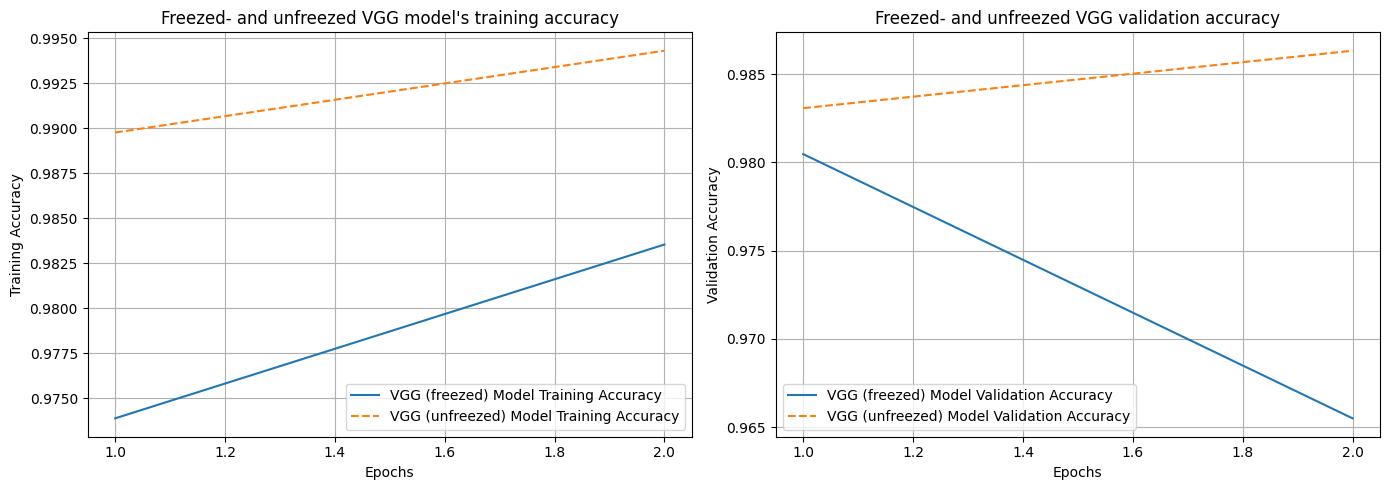

In [ ]:
# YOUR CODE HERE
compare_model_accuracy(vgg_train_accs, vgg_val_accs, vgg_unfreeze_train_accs, vgg_unfreeze_val_accs, vgg_batches_per_epoch, vgg_batches_per_epoch)

**(0 points)**

Why is it a good idea to use a very small learning rate when doing fine tuning?

**Your answer:** (fill in here)

A small learning rate during fine-tuning allows the model to gradually adapt to the new task, preserving the useful features learned from the pre-trained model and avoids drastic changes

Save the model to file.

In [ ]:
# YOUR CODE HERE
torch.save(
    {
        "model_state_dict": best_vgg_unfreeze_model,
        "train_losses": vgg_unfreeze_train_losses,
        "train_accs": vgg_unfreeze_train_accs,
        "val_losses": vgg_unfreeze_val_losses,
        "val_accs": vgg_unfreeze_val_accs,
    },
    "./vgg_unfreeze_model.ckpt",
)

### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [37]:
# YOUR CODE HERE
vgg_model2 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers
for param in vgg_model.features.parameters():
    param.requires_grad = False

head2 = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.PReLU(),
    nn.Dropout(0.4),

    nn.Linear(4096, 2048),
    nn.PReLU(),
    nn.Dropout(0.4),

    nn.Linear(2048, 512),
    nn.PReLU(),


    nn.Linear(512, 1),
    nn.Sigmoid(),
    nn.Flatten(start_dim=0)
)

vgg_model2.classifier = head2

# Train the new model

learning_rate = 0.0001
optimizer = optim.Adam(vgg_model2.parameters(), lr=learning_rate)
print_every = 10
loss_fn = nn.BCELoss()
num_epochs=3

vgg_model2, vgg2_train_losses, vgg2_train_accs, vgg2_val_losses, vgg2_val_accs, best_vgg_model2 = training_loop(
    model=vgg_model2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=num_epochs,
    print_every=print_every
)


Starting training
	Batch 10/55: 	Train loss: 0.476, 	Train acc.: 0.783, 	Val. loss: 0.295, 	Val. acc.: 0.885
	Batch 20/55: 	Train loss: 0.272, 	Train acc.: 0.884, 	Val. loss: 0.230, 	Val. acc.: 0.916
	Batch 30/55: 	Train loss: 0.230, 	Train acc.: 0.906, 	Val. loss: 0.255, 	Val. acc.: 0.893
	Batch 40/55: 	Train loss: 0.205, 	Train acc.: 0.925, 	Val. loss: 0.191, 	Val. acc.: 0.922
	Batch 50/55: 	Train loss: 0.194, 	Train acc.: 0.920, 	Val. loss: 0.195, 	Val. acc.: 0.926
Epoch 1/3: Train loss: 0.267, Train acc.: 0.888, Val. loss: 0.330, Val. acc.: 0.875
	Batch 10/55: 	Train loss: 0.110, 	Train acc.: 0.963, 	Val. loss: 0.219, 	Val. acc.: 0.918
	Batch 20/55: 	Train loss: 0.087, 	Train acc.: 0.972, 	Val. loss: 0.208, 	Val. acc.: 0.920
	Batch 30/55: 	Train loss: 0.095, 	Train acc.: 0.964, 	Val. loss: 0.191, 	Val. acc.: 0.931
	Batch 40/55: 	Train loss: 0.078, 	Train acc.: 0.972, 	Val. loss: 0.234, 	Val. acc.: 0.921
	Batch 50/55: 	Train loss: 0.083, 	Train acc.: 0.975, 	Val. loss: 0.259, 	Val. 

**(1 point)**

How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios. A point is awarded if your improvement helped.

In [45]:
def compare_model_accuracy(first_train_accs, first_val_accs, impr_train_accs, impr_val_accs, first_batches_per_epoch, impr_batches_per_epoch):
    # Plotting training and validation losses and accuracies

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    first_epoch_train_accs = [
        sum(first_train_accs[i * first_batches_per_epoch:(i + 1) * first_batches_per_epoch]) / first_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    impr_epoch_train_accs = [
        sum(impr_train_accs[i * impr_batches_per_epoch:(i + 1) * impr_batches_per_epoch]) / impr_batches_per_epoch
        for i in range(len(first_val_accs))
    ]

    epochs = range(1, len(first_val_accs) + 1)

    # Plot the loss on the first subplot
    ax1.plot(epochs, first_epoch_train_accs, label="VGG (unfreezed) Model Training Accuracy")
    ax1.plot(epochs, impr_epoch_train_accs, label="Finetuned VGG Model Training Accuracy", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Accuracy")
    ax1.set_title("Unfreezed- and finetuned VGG model's training accuracy")
    ax1.legend()
    ax1.grid(True)

    # Plot the accuracy on the second subplot
    ax2.plot(epochs, first_val_accs, label="VGG (freezed) Model Validation Accuracy")
    ax2.plot(epochs, impr_val_accs, label="VGG (unfreezed) Model Validation Accuracy", linestyle="--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Validation Accuracy")
    ax2.set_title("Unfreezed- and finetuned VGG validation accuracy")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

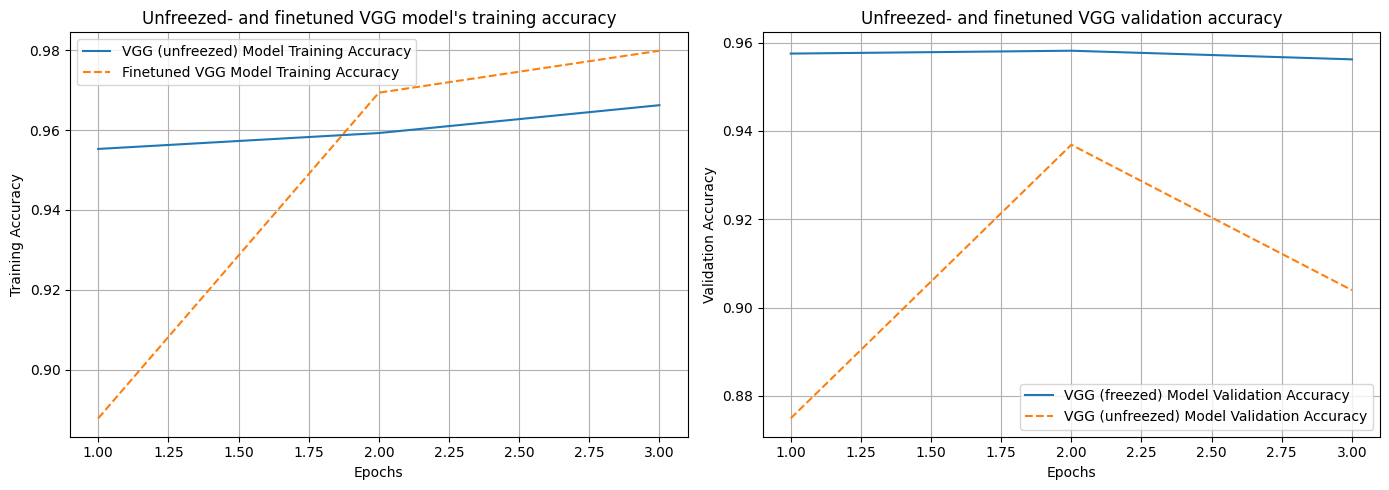

In [46]:
compare_model_accuracy(vgg_unfreeze_train_accs, vgg_unfreeze_val_accs, vgg2_train_accs, vgg2_val_accs, vgg_batches_per_epoch, vgg_batches_per_epoch)

Save the model to a file.

In [ ]:
torch.save(
    {
        "model_state_dict": best_vgg_model2,
        "train_losses": vgg2_train_losses,
        "train_accs": vgg2_train_accs,
        "val_losses": vgg2_val_losses,
        "val_accs": vgg2_val_accs,
    },
    "./vgg_model2.ckpt",
)

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data loaders, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [32]:
train_dataset = DogsCatsData(train_path, best_transformer)
val_dataset = DogsCatsData(val_path, best_transformer)

batch_size = 512 #To be empirically tested to find optimal size
num_workers = 8 #Test later if changing this will speed up training

full_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
full_val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

full_train_batches_per_epoch = int(len(train_dataset)/batch_size)+1

In [ ]:
# Test case for `full_train_dataloader` and `full_val_dataloader`
ha1_tests.test_dataloaders_for_final_training(full_train_dataloader, full_val_dataloader)

**(1 point)**

Train your model using the full data. This optimization might take a long time.

In [36]:
# The best model was the vgg that trained all layers. Although it differ in performance on different runs of the script, given the few eopchs
#checkpoint = torch.load("best_vgg_unfreeze_model.ckpt")


# Make sure that we can change all values
for param in vgg_model.features.parameters():
    param.requires_grad = True

best_model_vgg = vgg_model
#best_model_vgg.load_state_dict(checkpoint["model_state_dict"])

learning_rate = 0.00001
optimizer = optim.Adam(best_model_vgg.parameters(), lr=learning_rate)
num_epochs = 2
print_every = 10
loss_fn = nn.BCELoss()

best_model_vgg, best_train_losses, best_train_accs, best_val_losses, best_val_accs, best_best_model = training_loop(
    model=best_model_vgg,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=full_train_dataloader,
    val_loader=full_val_dataloader,
    num_epochs=num_epochs,
    print_every=print_every
)

Starting training
	Batch 10/40: 	Train loss: 0.418, 	Train acc.: 0.796, 	Val. loss: 0.212, 	Val. acc.: 0.911
	Batch 20/40: 	Train loss: 0.217, 	Train acc.: 0.912, 	Val. loss: 0.182, 	Val. acc.: 0.930
	Batch 30/40: 	Train loss: 0.190, 	Train acc.: 0.922, 	Val. loss: 0.162, 	Val. acc.: 0.938
	Batch 40/40: 	Train loss: 0.174, 	Train acc.: 0.926, 	Val. loss: 0.154, 	Val. acc.: 0.942
Epoch 1/2: Train loss: 0.250, Train acc.: 0.889, Val. loss: 0.154, Val. acc.: 0.942
	Batch 10/40: 	Train loss: 0.144, 	Train acc.: 0.942, 	Val. loss: 0.146, 	Val. acc.: 0.942
	Batch 20/40: 	Train loss: 0.142, 	Train acc.: 0.941, 	Val. loss: 0.145, 	Val. acc.: 0.945
	Batch 30/40: 	Train loss: 0.138, 	Train acc.: 0.943, 	Val. loss: 0.142, 	Val. acc.: 0.944
	Batch 40/40: 	Train loss: 0.146, 	Train acc.: 0.940, 	Val. loss: 0.135, 	Val. acc.: 0.948
Epoch 2/2: Train loss: 0.143, Train acc.: 0.942, Val. loss: 0.135, Val. acc.: 0.948


**(1 point)**

How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

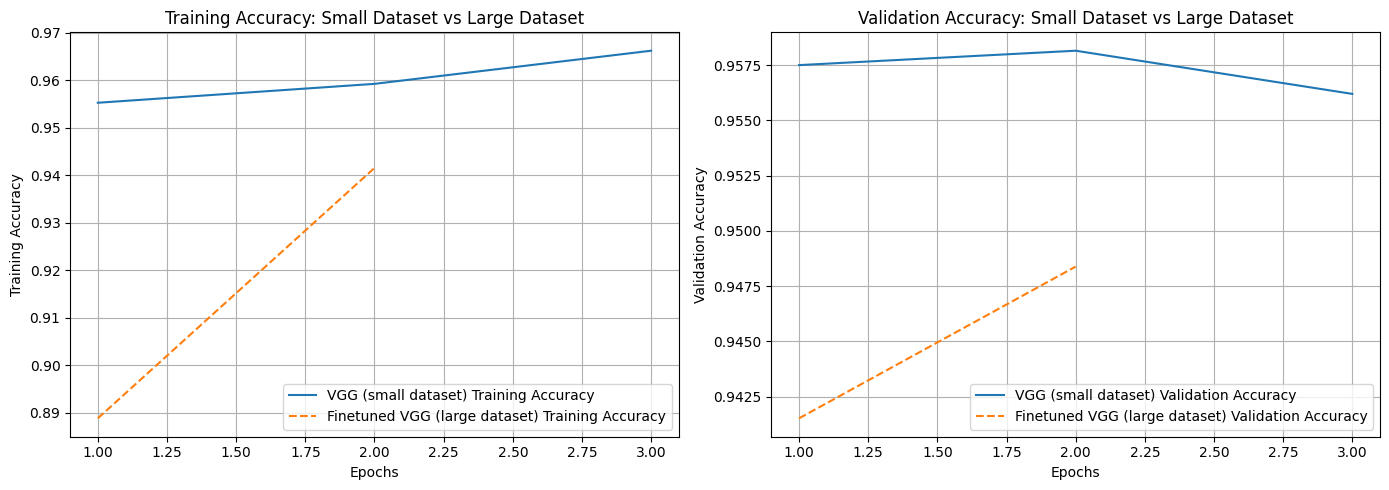

In [50]:
# YOUR CODE HERE
def compare_model_accuracy(first_train_accs, first_val_accs, impr_train_accs, impr_val_accs, first_batches_per_epoch, impr_batches_per_epoch):
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Calculate average training accuracy per epoch
    first_epoch_train_accs = [
        sum(first_train_accs[i * first_batches_per_epoch:(i + 1) * first_batches_per_epoch]) / first_batches_per_epoch
        for i in range(len(first_train_accs) // first_batches_per_epoch)
    ]

    impr_epoch_train_accs = [
        sum(impr_train_accs[i * impr_batches_per_epoch:(i + 1) * impr_batches_per_epoch]) / impr_batches_per_epoch
        for i in range(len(impr_train_accs) // impr_batches_per_epoch)
    ]

    # Determine the number of epochs based on the calculated accuracies
    first_epochs = range(1, len(first_epoch_train_accs) + 1)
    impr_epochs = range(1, len(impr_epoch_train_accs) + 1)

    # Plot the training accuracy on the first subplot
    ax1.plot(first_epochs, first_epoch_train_accs, label="VGG (small dataset) Training Accuracy")
    ax1.plot(impr_epochs, impr_epoch_train_accs, label="Finetuned VGG (large dataset) Training Accuracy", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Accuracy")
    ax1.set_title("Training Accuracy: Small Dataset vs Large Dataset")
    ax1.legend()
    ax1.grid(True)

    # Plot the validation accuracy on the second subplot
    ax2.plot(range(1, len(first_val_accs) + 1), first_val_accs, label="VGG (small dataset) Validation Accuracy")
    ax2.plot(range(1, len(impr_val_accs) + 1), impr_val_accs, label="Finetuned VGG (large dataset) Validation Accuracy", linestyle="--")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Validation Accuracy")
    ax2.set_title("Validation Accuracy: Small Dataset vs Large Dataset")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()
compare_model_accuracy(vgg_unfreeze_train_accs, vgg_unfreeze_val_accs, best_train_accs, best_val_accs, vgg_batches_per_epoch, full_train_batches_per_epoch)

**(2 points)**

- What can you conclude from these plots?
- Did you expect what you observe in the plots, explain!

**Your answer:** (fill in here)
The model perfomed better on the smaller data set which is not what we expected.
Different resons for this could be:

The model trained on the smaller dataset can easily overfit to the limited number of training samples. and even though we compare validation accuracy we have fine tuned the model for the validation so we have bias in the selection.

Given the fewer epochs, the model may not have enough time to learn the underlying patterns in the data fully. The smaller dataset, which may allow for quicker convergence, can yield misleadingly high performance metrics.

Training on large datasets typically requires more computational resources. As resorces are limited, experimenting with smaller datasets may yield quicker results and insights into model behavior and esier t finetune.

The inherent randomness in training  can lead to different performance outcomes on the smaller dataset across different runs. It’s possible that one run on a small dataset might yield an unusually high performance due to favorable conditions, which also happens, we get very different results for differents runs. Given the few epoch we did due to resorce limitations it is likely that the inital random weights do not have time to change enough

Save the model to a file.

In [ ]:
# YOUR CODE HERE

torch.save(
    {
        "model_state_dict": best_best_model,
        "train_losses": best_train_losses,
        "train_accs": best_train_accs,
        "val_losses": best_val_losses,
        "val_accs": best_val_accs,
    },
    "./best_model.ckpt",
)

## 6. Evaluation on test set (optional)

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labelled, so we can't compute any supervised performance metrics ourselves.

As a bit of fun and to inspire some friendly competition you may instead submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

For the test data we need a slightly different dataset class, due to the lack of labels in the data.
A more proper way to implement it would be to make a common class which handles both the train and test settings.
Here, we'll just copy the train dataset class and make some modifications to ignore the labels.

Hints:
- There is a `sampleSubmission.csv` file included in the zip data. Take a look at it to better understand what is the expected format here.
- If you don't know how to create and write to files with Python, it's a well-behaved Google search.

In [ ]:
from pathlib import Path
from time import time


class TestData(Dataset):
    def __init__(self, root: Path, transform):
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        path = self._samples[index]
        num_id = int(path.stem)
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, num_id

    def __len__(self):
        return len(self._samples)

    def _collect_samples(self):
        test_paths = self._collect_imgs_sub_dir(self.root)
        return sorted(list(test_paths), key=lambda path: int(path.stem))

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        if not sub_dir.exists():
            raise ValueError(f"Data root '{sub_dir}' does not exist.")
        return sub_dir.glob("*.jpg")

    def get_sample_by_id(self, id_):
        id_index = self._samples.index(id_)
        return self[id_index]


# YOUR CODE HERE

Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, but you can submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) via the "Late submission" button (they use the same data). The Kaggle CLI can be used as well. Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** (fill in here)

What was the username you used for this submission?

**Your answer:** (fill in here)